In [9]:
import _pipeline
import random


In [10]:
import json

# Bidi override characters
LRO = chr(0x202D)  # Left-to-Right Override
RLO = chr(0x202E)  # Right-to-Left Override
LRI = chr(0x2066)  # Left-to-Right Isolate
RLI = chr(0x2067)  # Right-to-Left Isolate
PDI = chr(0x2069)  # Pop Directional Isolate
PDF = chr(0x202C)  # Pop Directional Formatting



class TagAttack:
    def __init__(self, perturbation_budget, tags= [0xE0001,*range(0xE0020, 0xE007F+1)]):
        self.perturbation_budget = perturbation_budget
        self.tags = tags

    def perturb(self, text):
        """
        Insert random Unicode tag characters into text, treating each
        Unicode codepoint as a single character.
        """
        # Convert string to list of codepoints
        codepoints = [ord(c) for c in text]

        for i in range(self.perturbation_budget):
            # Choose random position in codepoint list
            rand_index = random.randrange(len(codepoints) + 1)  # +1 to allow appending
            rand_tag = random.choice(self.tags)

            # Insert the tag codepoint at the chosen position
            codepoints.insert(rand_index, rand_tag)

        # Convert back to string
        return "".join(chr(cp) for cp in codepoints)


class VariationSelectorAttack:
    def __init__(self, perturbation_budget, variation_selectors = [*range(0xFE00, 0xFE0F + 1), *range(0xE0100, 0xE01EF + 1)]):
        self.perturbation_budget = perturbation_budget
        self.variation_selectors = variation_selectors

    def perturb(self, text):
        # Convert string to list of codepoints
        codepoints = [ord(c) for c in text]

        for _ in range(self.perturbation_budget):
            # Choose random position in codepoint list
            rand_index = random.randrange(len(codepoints) + 1)  # allow append
            rand_vs = random.choice(self.variation_selectors)

            # Insert the variation selector codepoint
            codepoints.insert(rand_index, rand_vs)

        # Convert back to string
        return "".join(chr(cp) for cp in codepoints)


class InvisibleCharAttack:
    def __init__(self, perturbation_budget, invisible_chars=[0x200B, 0x200C, 0x200D, 0x2060, 0xFEFF]):
        self.perturbation_budget = perturbation_budget
        self.invisible_chars = invisible_chars

    def perturb(self, text):
        # Convert string to list of codepoints
        codepoints = [ord(c) for c in text]

        for _ in range(self.perturbation_budget):
            # Choose random position in codepoint list
            rand_index = random.randrange(len(codepoints) + 1)  # allow append
            rand_invisible = random.choice(self.invisible_chars)

            # Insert the invisible character
            codepoints.insert(rand_index, rand_invisible)

        # Convert back to string
        return "".join(chr(cp) for cp in codepoints)


class HomoglyphAttack:
    def __init__(self, perturbation_budget, homoglyph_map_path='/home/carolkhor/YearII/Dissertation/imperceptible-perturbations/project/utils/homoglyphs/intentional.json'):
        self.perturbation_budget = perturbation_budget
        with open(homoglyph_map_path, 'r') as f:
            hex_map = json.load(f)
        # Convert hex strings to codepoints
        self.homoglyph_map = {int(k, 16): int(v, 16) for k, v in hex_map.items()}
        self.homoglyph_chars = list(self.homoglyph_map.keys())

    def perturb(self, text):
        # Convert string to list of codepoints
        codepoints = [ord(c) for c in text]
        
        # Replace random characters with homoglyphs
        indices = list(range(len(codepoints)))
        random.shuffle(indices)
        
        for i in indices[:min(self.perturbation_budget, len(indices))]:
            cp = codepoints[i]
            # If character has a homoglyph, replace it
            if cp in self.homoglyph_map:
                codepoints[i] = self.homoglyph_map[cp]

        # Convert back to string
        return "".join(chr(cp) for cp in codepoints)


class DeletionCharAttack:
    def __init__(self, perturbation_budget, deletion_char=0x8):
        self.perturbation_budget = perturbation_budget
        self.deletion_char = deletion_char  # Backspace character
        self.ascii_chars = list(range(32, 127))  # Printable ASCII characters

    def perturb(self, text):
        # Convert string to list of codepoints
        codepoints = [ord(c) for c in text]
        
        for _ in range(self.perturbation_budget):
            # Choose random position in codepoint list
            rand_index = random.randrange(len(codepoints) + 1)  # allow append
            # Insert random ASCII character followed by deletion character
            rand_ascii = random.choice(self.ascii_chars)
            codepoints.insert(rand_index, rand_ascii)
            codepoints.insert(rand_index + 1, self.deletion_char)

        # Convert back to string
        return "".join(chr(cp) for cp in codepoints)

import json
import random

# Bidi override characters
RLO = chr(0x202E)   # Right-to-Left Override
PDF = chr(0x202C)   # Pop Directional Formatting
RLI = chr(0x2067)   # Right-to-Left Isolate
PDI = chr(0x2069)   # Pop Directional Isolate
LRO = chr(0x202D)   # Left-to-Right Override
LRI = chr(0x2066)   # Left-to-Right Isolate
# ... (Other classes like Swap, TagAttack, etc., remain unchanged) ...

class BidiAttack:
    def __init__(self, perturbation_budget):
        self.perturbation_budget = perturbation_budget
    
    def _encode_swap_spoof(self, one, two):
        """
        Creates a string that contains the characters 'two' followed by 'one' 
        in the data, but is displayed as 'one' followed by 'two'.
        Sequence: RLO + two + one + PDF
        """
        # LRO, LRI, RLO, LRI, el.two, PDI, LRI, el.one, PDI, PDF, PDI, PDF
        
        # Display order is visually reversed by RLO
        return LRO + LRI+ RLO + LRI + two + PDI + LRI + one + PDI + PDF + PDI + PDF

    def perturb(self, text):
        """
        Swaps random *non-overlapping* adjacent character pairs in the 
        underlying data and uses Bidi controls to visually reverse the swap.
        """
        chars = list(text)
        n = len(chars)
        
        possible_start_indices = list(range(n - 1))
        random.shuffle(possible_start_indices)
        
        swaps_to_make = set()
        swaps_remaining = self.perturbation_budget
        
        # Select non-overlapping swap positions
        for i in possible_start_indices:
            if i not in swaps_to_make and i + 1 not in swaps_to_make:
                if swaps_remaining > 0:
                    swaps_to_make.add(i)
                    # Add the next index to the set to prevent it from starting a new swap
                    swaps_to_make.add(i + 1) 
                    swaps_remaining -= 1
                else:
                    break

        swaps_to_make = []
        available_positions = list(range(n - 1))
        random.shuffle(available_positions)
        
        processed_indices = set()
        
        for pos in available_positions:
            # A swap starts at 'pos' and involves 'pos' and 'pos + 1'
            if pos not in processed_indices and (pos + 1) not in processed_indices:
                if len(swaps_to_make) < self.perturbation_budget:
                    swaps_to_make.append(pos)
                    # Mark both characters in the pair as 'used'
                    processed_indices.add(pos)
                    processed_indices.add(pos + 1)
                else:
                    break
        
        
        # Build perturbed text
        perturbed_text = ""
        i = 0
        while i < n:
            if i in swaps_to_make and chars[i].isalpha() and chars[i + 1].isalpha():
                # This index starts a swap
                char_one = chars[i]
                char_two = chars[i + 1]
                
                # Data: two, one (visually displays as: one, two)
                spoofed_pair = self._encode_swap_spoof(char_one, char_two)
                perturbed_text += spoofed_pair
                
                # Advance counter by 2 since both characters were processed
                i += 2 
            else:
                # Add normal character
                perturbed_text += chars[i]
                i += 1
                
        return perturbed_text

In [11]:
txt = " ."
txt = "ab"
bidi_attack = BidiAttack(perturbation_budget=2)
invis_attack = InvisibleCharAttack(perturbation_budget=2)
perturbed = bidi_attack.perturb(txt)
perturbed = invis_attack.perturb(perturbed)
print(f"Perturbed: '{perturbed}'")
print(f"Length in codepoints: {len(perturbed)}")
print(f"Codepoints: {[hex(ord(c)) for c in perturbed]}")

p = _pipeline.Pipeline()
p.add_bidi_sanitizer()
p.add_invisible_sanitizer()
sanitised = p.sanitize(perturbed)
print(txt == sanitised)


print(f"Sanitised: {[hex(ord(c)) for c in sanitised]}")
print(f"Text: {[hex(ord(c)) for c in txt]}")

Perturbed: '‭⁦‮⁦b⁩⁦a⁠⁩‍‬⁩‬'
Length in codepoints: 14
Codepoints: ['0x202d', '0x2066', '0x202e', '0x2066', '0x62', '0x2069', '0x2066', '0x61', '0x2060', '0x2069', '0x200d', '0x202c', '0x2069', '0x202c']
True
Sanitised: ['0x61', '0x62']
Text: ['0x61', '0x62']


In [12]:
delAttack = DeletionCharAttack(perturbation_budget=3)
txt = "abc"
del_text = delAttack.perturb(txt)
print(f"Perturbed: '{del_text}'")
print(f"Length in codepoints: {len(del_text)}")
print(f"Codepoints: {[hex(ord(c)) for c in del_text]}")

p = _pipeline.Pipeline()
p.add_deletion_sanitizer()
sanitised = p.sanitize(del_text)
print(f"Sanitised: {[hex(ord(c)) for c in sanitised]}")

Perturbed: 'abc'
Length in codepoints: 9
Codepoints: ['0x61', '0x62', '0x63', '0x23', '0x8', '0x50', '0x8', '0x59', '0x8']
Sanitised: ['0x61', '0x62', '0x63']


In [13]:
tagAttack = TagAttack(perturbation_budget=3)
txt = "abc"
tag_text = tagAttack.perturb(txt)
print(f"Perturbed: '{tag_text}'")
print(f"Length in codepoints: {len(tag_text)}")
print(f"Codepoints: {[hex(ord(c)) for c in tag_text]}")

p = _pipeline.Pipeline()
p.add_tag_sanitizer()
sanitised = p.sanitize(tag_text)
print(f"Sanitised: {[hex(ord(c)) for c in sanitised]}")

Perturbed: '󠁁a󠁇b󠁉c'
Length in codepoints: 6
Codepoints: ['0xe0041', '0x61', '0xe0047', '0x62', '0xe0049', '0x63']
Sanitised: ['0x61', '0x62', '0x63']


In [14]:
variationSelectorAttack = VariationSelectorAttack(perturbation_budget=3)
perturbed = variationSelectorAttack.perturb("abc")
print(f"Perturbed: '{perturbed}'")
print(f"Length in codepoints: {len(perturbed)}")
print(f"Codepoints: {[hex(ord(c)) for c in perturbed]}")

p = _pipeline.Pipeline()
p.add_variation_selector_sanitizer()
sanitised = p.sanitize(perturbed)
print(f"Sanitised: {[hex(ord(c)) for c in sanitised]}")

Perturbed: '󠇕a󠆔󠄘bc'
Length in codepoints: 6
Codepoints: ['0xe01d5', '0x61', '0xe0194', '0xe0118', '0x62', '0x63']
Sanitised: ['0x61', '0x62', '0x63']


# Example Sentiment Analysis Task

In [53]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# 1. Load the pre-trained model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 2. Prepare the input text
text = "RoBERTa is an incredibly powerful model for NLP tasks!"

# 3. Tokenize and predict
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

# 4. Interpret the result
scores = output.logits[0].detach().numpy()
# Get the predicted class index (e.g., 0, 1, or 2)
predicted_class_id = scores.argmax()

# The model's config contains the mapping from ID to label
labels = model.config.id2label
predicted_label = labels[predicted_class_id]

print(f"Text: {text}")
print(f"Predicted Sentiment: {predicted_label}")
# Output for this example would likely be: Predicted Sentiment: LABEL_2 (Positive)

Text: RoBERTa is an incredibly powerful model for NLP tasks!
Predicted Sentiment: LABEL_2


# Sanitizer Performance Timing

In [57]:
import csv
import time
import pandas as pd
from datasets import load_dataset

# Configuration
perturbation_budgets = range(0, 2000,100)
num_samples = 50
output_file = "all_attacks_results.csv"

print(f"Perturbation budgets: {list(perturbation_budgets)}")
print(f"Samples per budget: {num_samples}\n")

# Load dataset
sst2 = load_dataset("glue", "sst2", split="validation")
texts = sst2['sentence'][:num_samples]


results = []

for budget in perturbation_budgets:
    print(f"Budget {budget}...", end=" ")
    
    # All six attacks
    tag_attack = TagAttack(perturbation_budget=budget)
    vs_attack = VariationSelectorAttack(perturbation_budget=budget)
    invisible_attack = InvisibleCharAttack(perturbation_budget=budget)
    homoglyph_attack = HomoglyphAttack(perturbation_budget=budget)
    deletion_attack = DeletionCharAttack(perturbation_budget=budget)
    bidi_attack = BidiAttack(perturbation_budget=budget)
    
    # Apply all attacks sequentially to each text
    all_attacks_perturbed = []
    for text in texts:
        perturbed = tag_attack.perturb(text)
        perturbed = vs_attack.perturb(perturbed)
        perturbed = invisible_attack.perturb(perturbed)
        perturbed = homoglyph_attack.perturb(perturbed)
        perturbed = deletion_attack.perturb(perturbed)
        perturbed = bidi_attack.perturb(perturbed)
        all_attacks_perturbed.append(perturbed)
    
    # Run all sanitizers in single pipeline
    p_all = _pipeline.Pipeline()
    p_all.add_bidi_sanitizer()
    p_all.add_tag_sanitizer()
    p_all.add_variation_selector_sanitizer()
    p_all.add_invisible_sanitizer()
    p_all.add_homoglyph_sanitizer()
    p_all.add_deletion_sanitizer()
    
    
    start = time.time()
    sanitized_all = [p_all.sanitize(text) for text in all_attacks_perturbed]
    sanitize_time_all = (time.time() - start) / num_samples * 1000
    
    recovered_all = sum(1 for i in range(num_samples) if sanitized_all[i] == texts[i])
    recovery_rate_all = recovered_all / num_samples * 100
    
    results.append({
        'budget': budget,
        'sanitize_ms': f"{sanitize_time_all:.2f}",
        'recovered': f"{recovered_all}/{num_samples}",
        'recovery_rate': f"{recovery_rate_all:.1f}%"
    })

# Save to CSV
csv_columns = ['budget', 'sanitize_ms', 'recovered', 'recovery_rate']
with open(output_file, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=csv_columns)
    writer.writeheader()
    writer.writerows(results)

print("done")
print(f"\nResults saved to {output_file}\n")


Perturbation budgets: [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]
Samples per budget: 50

Budget 0... Budget 100... Budget 0... Budget 100... Budget 200... Budget 200... Budget 300... Budget 300... Budget 400... Budget 400... Budget 500... Budget 500... Budget 600... Budget 600... Budget 700... Budget 700... Budget 800... Budget 800... Budget 900... Budget 900... Budget 1000... Budget 1000... Budget 1100... Budget 1100... Budget 1200... Budget 1200... Budget 1300... Budget 1300... Budget 1400... Budget 1400... Budget 1500... Budget 1500... Budget 1600... Budget 1600... Budget 1700... Budget 1700... Budget 1800... Budget 1800... Budget 1900... Budget 1900... done

Results saved to all_attacks_results.csv

done

Results saved to all_attacks_results.csv



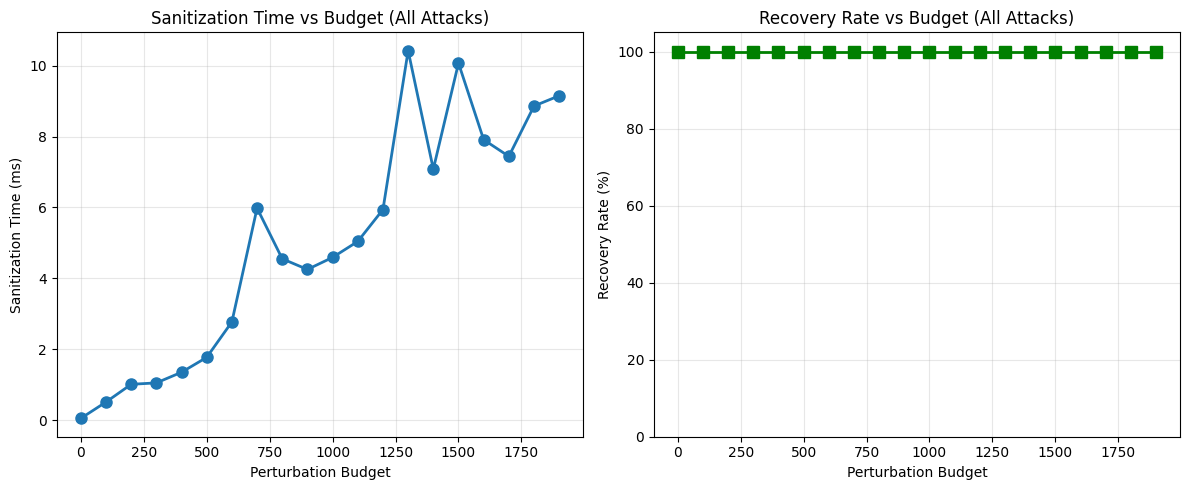


Results Summary:
 budget sanitize_ms recovered recovery_rate  sanitize_ms_num  recovery_rate_num
      0        0.05     50/50        100.0%             0.05              100.0
    100        0.51     50/50        100.0%             0.51              100.0
    200        1.01     50/50        100.0%             1.01              100.0
    300        1.05     50/50        100.0%             1.05              100.0
    400        1.35     50/50        100.0%             1.35              100.0
    500        1.77     50/50        100.0%             1.77              100.0
    600        2.77     50/50        100.0%             2.77              100.0
    700        5.98     50/50        100.0%             5.98              100.0
    800        4.55     50/50        100.0%             4.55              100.0
    900        4.25     50/50        100.0%             4.25              100.0
   1000        4.59     50/50        100.0%             4.59              100.0
   1100        5.04   

In [58]:
import matplotlib.pyplot as plt

# Display results
summary_df = pd.DataFrame(results)

# Convert numeric columns for plotting
summary_df['sanitize_ms_num'] = summary_df['sanitize_ms'].astype(float)
summary_df['recovery_rate_num'] = summary_df['recovery_rate'].str.rstrip('%').astype(float)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Sanitization time vs budget
axes[0].plot(summary_df['budget'], summary_df['sanitize_ms_num'], marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Perturbation Budget')
axes[0].set_ylabel('Sanitization Time (ms)')
axes[0].set_title('Sanitization Time vs Budget (All Attacks)')
axes[0].grid(True, alpha=0.3)

# Plot 2: Recovery rate vs budget
axes[1].plot(summary_df['budget'], summary_df['recovery_rate_num'], marker='s', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Perturbation Budget')
axes[1].set_ylabel('Recovery Rate (%)')
axes[1].set_title('Recovery Rate vs Budget (All Attacks)')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 105])

plt.tight_layout()
plt.show()

print("\nResults Summary:")
print(summary_df.to_string(index=False))


In [42]:
budget = 1

# tag_attack = TagAttack(perturbation_budget=budget)
# vs_attack = VariationSelectorAttack(perturbation_budget=budget)
invisible_attack = InvisibleCharAttack(perturbation_budget=budget)
homoglyph_attack = HomoglyphAttack(perturbation_budget=budget)
deletion_attack = DeletionCharAttack(perturbation_budget=budget)
bidi_attack = BidiAttack(perturbation_budget=budget)
    
    
perturbed = tag_attack.perturb(text)
perturbed = vs_attack.perturb(perturbed)
perturbed = invisible_attack.perturb(perturbed)
perturbed = homoglyph_attack.perturb(perturbed)
perturbed = deletion_attack.perturb(perturbed)
perturbed = bidi_attack.perturb(perturbed)

print([hex(ord(c)) for c in perturbed])
print([hex(ord(c)) for c in text])

# 3. Tokenize and predict
encoded_input = tokenizer(perturbed, return_tensors='pt')
output = model(**encoded_input)

# 4. Interpret the result
scores = output.logits[0].detach().numpy()
# Get the predicted class index (e.g., 0, 1, or 2)
predicted_class_id = scores.argmax()

# The model's config contains the mapping from ID to label
labels = model.config.id2label
predicted_label = labels[predicted_class_id]

print(f"Text: {text}")
print(f"Predicted Sentiment: {predicted_label}")

['0x52', '0x6f', '0x42', '0x45', '0x52', '0x54', '0x61', '0x20', '0x69', '0x73', '0x20', '0x61', '0x6e', '0xe0181', '0x20', '0x69', '0x6e', '0xe0036', '0x63', '0x72', '0x65', '0x64', '0x31', '0x8', '0x69', '0x62', '0x6c', '0x79', '0x20', '0x70', '0x6f', '0x77', '0x65', '0x200b', '0x72', '0x66', '0x75', '0x6c', '0x20', '0x202d', '0x2066', '0x202e', '0x2066', '0x6f', '0x2069', '0x2066', '0x6d', '0x2069', '0x202c', '0x2069', '0x202c', '0x64', '0x65', '0x6c', '0x20', '0x66', '0x6f', '0x72', '0x20', '0x4e', '0x4c', '0x50', '0x20', '0x74', '0x61', '0x73', '0x6b', '0x73', '0x21']
['0x52', '0x6f', '0x42', '0x45', '0x52', '0x54', '0x61', '0x20', '0x69', '0x73', '0x20', '0x61', '0x6e', '0x20', '0x69', '0x6e', '0x63', '0x72', '0x65', '0x64', '0x69', '0x62', '0x6c', '0x79', '0x20', '0x70', '0x6f', '0x77', '0x65', '0x72', '0x66', '0x75', '0x6c', '0x20', '0x6d', '0x6f', '0x64', '0x65', '0x6c', '0x20', '0x66', '0x6f', '0x72', '0x20', '0x4e', '0x4c', '0x50', '0x20', '0x74', '0x61', '0x73', '0x6b', '0x

# Sentiment Analysis Full Experiment

In [59]:

# Sentiment Classification Attack Experiment
# Test before/after perturbation + after sanitization for each attack type on SST-2

import pandas as pd
import numpy as np
from datasets import load_dataset

# Load SST-2 dataset
print("Loading SST-2 dataset...")
sst2 = load_dataset("glue", "sst2", split="validation")
num_samples = 100  # Use first 100 samples for experiment
texts = sst2['sentence'][:num_samples]

# Initialize lists to store results
results = []

# Perturbation budgets to test
budgets = list(range(0, 11))  # 0 to 5

print(f"Testing {num_samples} samples across budgets: {budgets}\n")

# Define attack types
attack_types = ['tag', 'variation_selector', 'invisible', 'homoglyph', 'deletion', 'bidi', 'combined']

# Attack to Sanitizer mapping
attack_sanitizer_map = {
    'tag': 'add_tag_sanitizer',
    'variation_selector': 'add_variation_selector_sanitizer',
    'invisible': 'add_invisible_sanitizer',
    'homoglyph': 'add_homoglyph_sanitizer',
    'deletion': 'add_deletion_sanitizer',
    'bidi': 'add_bidi_sanitizer',
    'combined': 'all'  # Special case: use all sanitizers
}

# Process each budget
for budget in budgets:
    print(f"\n=== Budget: {budget} ===")
    
    # Initialize attacks
    tag_attack = TagAttack(perturbation_budget=budget)
    vs_attack = VariationSelectorAttack(perturbation_budget=budget)
    invisible_attack = InvisibleCharAttack(perturbation_budget=budget)
    homoglyph_attack = HomoglyphAttack(perturbation_budget=budget)
    deletion_attack = DeletionCharAttack(perturbation_budget=budget)
    bidi_attack = BidiAttack(perturbation_budget=budget)
    
    # Get predictions for original texts (budget 0 for efficiency)
    if budget == 0:
        print("Getting baseline predictions for original texts...")
        original_preds = []
        original_probs = []
        
        for i, text in enumerate(texts):
            encoded = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
            with torch.no_grad():
                output = model(**encoded)
            scores = output.logits[0].detach().numpy()
            pred_id = scores.argmax()
            pred_prob = scores.max()
            original_preds.append(model.config.id2label[pred_id])
            original_probs.append(pred_prob)
            
            if (i + 1) % 20 == 0:
                print(f"  Processed {i + 1}/{num_samples} samples")
    
    # Test each attack type
    for attack_name in attack_types:
        print(f"  Testing {attack_name} attack...", end=" ", flush=True)
        
        perturbed_preds = []
        perturbed_probs = []
        sanitized_preds = []
        sanitized_probs = []
        
        for text in texts:
            # Apply attack
            if attack_name == 'tag':
                perturbed = tag_attack.perturb(text)
            elif attack_name == 'variation_selector':
                perturbed = vs_attack.perturb(text)
            elif attack_name == 'invisible':
                perturbed = invisible_attack.perturb(text)
            elif attack_name == 'homoglyph':
                perturbed = homoglyph_attack.perturb(text)
            elif attack_name == 'deletion':
                perturbed = deletion_attack.perturb(text)
            elif attack_name == 'bidi':
                perturbed = bidi_attack.perturb(text)
            elif attack_name == 'combined':
                perturbed = tag_attack.perturb(text)
                perturbed = vs_attack.perturb(perturbed)
                perturbed = invisible_attack.perturb(perturbed)
                perturbed = homoglyph_attack.perturb(perturbed)
                perturbed = deletion_attack.perturb(perturbed)
                perturbed = bidi_attack.perturb(perturbed)
            
            # Get prediction on perturbed text
            encoded = tokenizer(perturbed, return_tensors='pt', max_length=512, truncation=True)
            with torch.no_grad():
                output = model(**encoded)
            scores = output.logits[0].detach().numpy()
            pred_id = scores.argmax()
            pred_prob = scores.max()
            perturbed_preds.append(model.config.id2label[pred_id])
            perturbed_probs.append(pred_prob)
            
            # Apply sanitizers to the perturbed text
            p = _pipeline.Pipeline()
            if attack_sanitizer_map[attack_name] == 'all':
                p.add_bidi_sanitizer()
                p.add_tag_sanitizer()
                p.add_variation_selector_sanitizer()
                p.add_invisible_sanitizer()
                p.add_homoglyph_sanitizer()
                p.add_deletion_sanitizer()
            else:
                getattr(p, attack_sanitizer_map[attack_name])()
            
            sanitized = p.sanitize(perturbed)
            
            # Get prediction on sanitized text
            encoded = tokenizer(sanitized, return_tensors='pt', max_length=512, truncation=True)
            with torch.no_grad():
                output = model(**encoded)
            scores = output.logits[0].detach().numpy()
            pred_id = scores.argmax()
            pred_prob = scores.max()
            sanitized_preds.append(model.config.id2label[pred_id])
            sanitized_probs.append(pred_prob)
        
        # Calculate metrics
        attack_success_rate = sum(1 for i in range(num_samples) if perturbed_preds[i] != original_preds[i]) / num_samples * 100
        defense_recovery_rate = sum(1 for i in range(num_samples) if sanitized_preds[i] == original_preds[i]) / num_samples * 100
        avg_perturb_prob_drop = np.mean([original_probs[i] - perturbed_probs[i] for i in range(num_samples)])
        
        results.append({
            'budget': budget,
            'attack': attack_name,
            'attack_success_rate': f"{attack_success_rate:.1f}%",
            'defense_recovery_rate': f"{defense_recovery_rate:.1f}%",
            'avg_perturb_prob_drop': f"{avg_perturb_prob_drop:.4f}"        })
        
        print(f"Attack Success: {attack_success_rate:.1f}% | Defense Recovery: {defense_recovery_rate:.1f}%")

# Create results dataframe
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("EXPERIMENT RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))

# Save to CSV
csv_file = "sentiment_attack_defense_results.csv"
results_df.to_csv(csv_file, index=False)
print(f"\nResults saved to {csv_file}")


Loading SST-2 dataset...
Testing 100 samples across budgets: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


=== Budget: 0 ===
Getting baseline predictions for original texts...
Testing 100 samples across budgets: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


=== Budget: 0 ===
Getting baseline predictions for original texts...
  Processed 20/100 samples
  Processed 20/100 samples
  Processed 40/100 samples
  Processed 40/100 samples
  Processed 60/100 samples
  Processed 60/100 samples
  Processed 80/100 samples
  Processed 80/100 samples
  Processed 100/100 samples
  Testing tag attack...   Processed 100/100 samples
  Testing tag attack... Attack Success: 0.0% | Defense Recovery: 100.0%
  Testing variation_selector attack... Attack Success: 0.0% | Defense Recovery: 100.0%
  Testing variation_selector attack... Attack Success: 0.0% | Defense Recovery: 100.0%
  Testing invisible attack... Attack Success: 0.0% | Defense Recovery: 100.0%
  Testing invisible attack... Attack Success: 0.0% | Defense Recovery: 

In [66]:
results_df.head()

,budget,attack,attack_success_rate,defense_recovery_rate,avg_perturb_prob_drop,attack_success_rate_num,defense_recovery_rate_num,avg_perturb_prob_drop_num
0,0,tag,0.0%,100.0%,0.0000,0.0,100.0,0.0
1,0,variation_selector,0.0%,100.0%,0.0000,0.0,100.0,0.0
2,0,invisible,0.0%,100.0%,0.0000,0.0,100.0,0.0
3,0,homoglyph,0.0%,100.0%,0.0000,0.0,100.0,0.0
4,0,deletion,0.0%,100.0%,0.0000,0.0,100.0,0.0


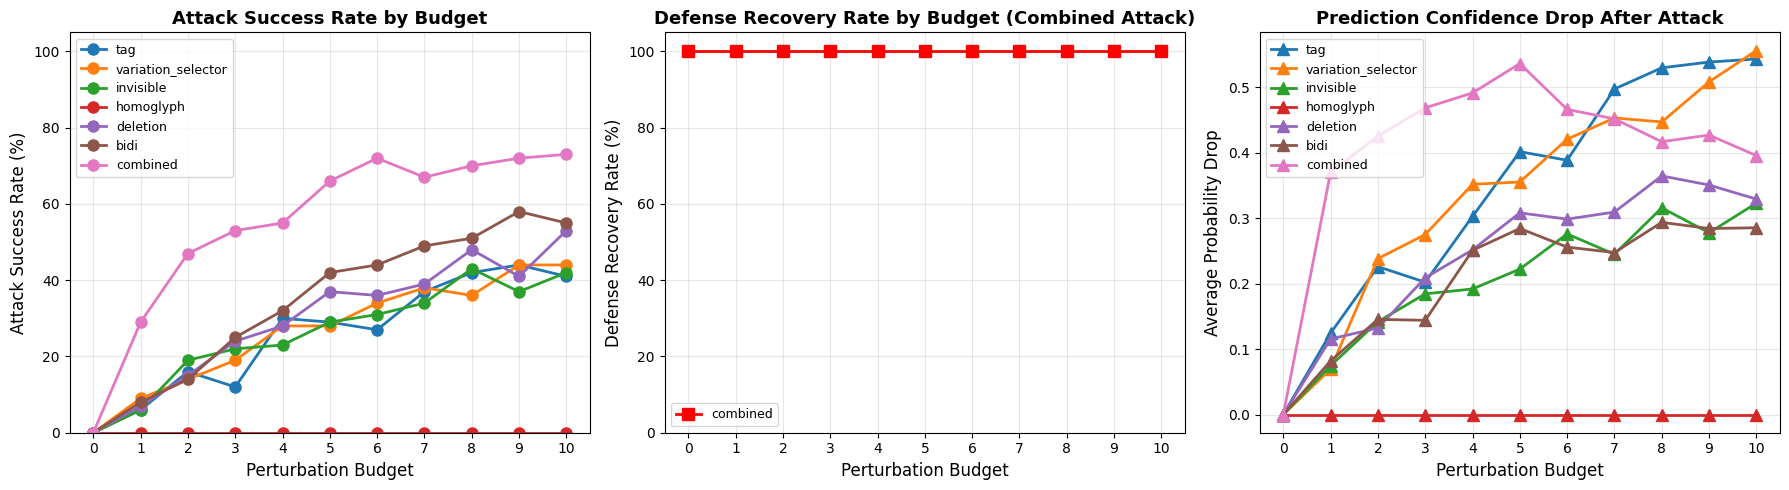


Visualization complete!


In [69]:

# Visualization: Attack Success vs Defense Recovery by Budget and Attack Type

import matplotlib.pyplot as plt

# Parse the results dataframe for plotting
results_df['attack_success_rate_num'] = results_df['attack_success_rate'].str.rstrip('%').astype(float)
results_df['defense_recovery_rate_num'] = results_df['defense_recovery_rate'].str.rstrip('%').astype(float)
results_df['avg_perturb_prob_drop_num'] = results_df['avg_perturb_prob_drop_num'].astype(float)

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Attack Success Rate vs Budget
for attack in attack_types:
    attack_data = results_df[results_df['attack'] == attack]
    axes[0].plot(attack_data['budget'], attack_data['attack_success_rate_num'], 
                marker='o', label=attack, linewidth=2, markersize=8)

axes[0].set_xlabel('Perturbation Budget', fontsize=12)
axes[0].set_ylabel('Attack Success Rate (%)', fontsize=12)
axes[0].set_title('Attack Success Rate by Budget', fontsize=13, fontweight='bold')
axes[0].legend(loc='best', fontsize=9)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(budgets)
axes[0].set_ylim([0, 105])

# Plot 2: Defense Recovery Rate vs Budget (Combined only)
combined_data = results_df[results_df['attack'] == 'combined']
axes[1].plot(combined_data['budget'], combined_data['defense_recovery_rate_num'], 
            marker='s', label='combined', linewidth=2, markersize=8, color='red')

axes[1].set_xlabel('Perturbation Budget', fontsize=12)
axes[1].set_ylabel('Defense Recovery Rate (%)', fontsize=12)
axes[1].set_title('Defense Recovery Rate by Budget (Combined Attack)', fontsize=13, fontweight='bold')
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(budgets)
axes[1].set_ylim([0, 105])

# Plot 3: Prediction Probability Drop vs Budget
for attack in attack_types:
    attack_data = results_df[results_df['attack'] == attack]
    axes[2].plot(attack_data['budget'], attack_data['avg_perturb_prob_drop_num'], 
                marker='^', label=attack, linewidth=2, markersize=8)

axes[2].set_xlabel('Perturbation Budget', fontsize=12)
axes[2].set_ylabel('Average Probability Drop', fontsize=12)
axes[2].set_title('Prediction Confidence Drop After Attack', fontsize=13, fontweight='bold')
axes[2].legend(loc='best', fontsize=9)
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(budgets)

plt.tight_layout()
plt.show()
fig.savefig("attack_defense_visualization.png")
print("\nVisualization complete!")


In [49]:

# Detailed Analysis: Compare attack vs defense at each budget level

print("\n" + "="*80)
print("DETAILED ATTACK vs DEFENSE ANALYSIS BY BUDGET")
print("="*80)

for budget in budgets:
    print(f"\n--- Budget {budget} ---")
    budget_results = results_df[results_df['budget'] == budget].sort_values('attack_success_rate_num', ascending=False)
    
    print(f"\nRanking by Attack Success Rate (Before Defense):")
    for idx, row in budget_results.iterrows():
        print(f"  {row['attack']:20} | Attack: {row['attack_success_rate']:>6} | Recovery: {row['defense_recovery_rate']:>6} | Prob: {row['avg_perturb_prob_drop']:>8}")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

print("\nAttack Effectiveness (Average across all budgets):")
attack_summary = results_df.groupby('attack').agg({
    'attack_success_rate_num': 'mean',
    'defense_recovery_rate_num': 'mean',
    'avg_perturb_prob_drop_num': 'mean',
    'avg_sanitize_prob_recovery_num': 'mean'
}).round(2)
attack_summary.columns = ['Avg Attack Success (%)', 'Avg Defense Recovery (%)', 'Avg Prob Drop', 'Avg Prob Recovery']
attack_summary = attack_summary.sort_values('Avg Attack Success (%)', ascending=False)
print(attack_summary)

print("\nBudget Effectiveness (Average across all attacks):")
budget_summary = results_df.groupby('budget').agg({
    'attack_success_rate_num': 'mean',
    'defense_recovery_rate_num': 'mean',
    'avg_perturb_prob_drop_num': 'mean',
    'avg_sanitize_prob_recovery_num': 'mean'
}).round(2)
budget_summary.columns = ['Avg Attack Success (%)', 'Avg Defense Recovery (%)', 'Avg Prob Drop', 'Avg Prob Recovery']
print(budget_summary)

# Defense Effectiveness per Attack
print("\nDefense Effectiveness by Attack Type (Recovery Rate Gain from Sanitization):")
defense_effectiveness = results_df.copy()
defense_effectiveness['recovery_improvement'] = defense_effectiveness['defense_recovery_rate_num'] - (100 - defense_effectiveness['attack_success_rate_num'])
defense_effectiveness = defense_effectiveness.groupby('attack')['recovery_improvement'].mean().round(2).sort_values(ascending=False)
print(defense_effectiveness)



DETAILED ATTACK vs DEFENSE ANALYSIS BY BUDGET

--- Budget 0 ---

Ranking by Attack Success Rate (Before Defense):
  tag                  | Attack:   0.0% | Recovery: 100.0% | Prob:   0.0000
  variation_selector   | Attack:   0.0% | Recovery: 100.0% | Prob:   0.0000
  invisible            | Attack:   0.0% | Recovery: 100.0% | Prob:   0.0000
  homoglyph            | Attack:   0.0% | Recovery: 100.0% | Prob:   0.0000
  deletion             | Attack:   0.0% | Recovery: 100.0% | Prob:   0.0000
  bidi                 | Attack:   0.0% | Recovery: 100.0% | Prob:   0.0000
  combined             | Attack:   0.0% | Recovery: 100.0% | Prob:   0.0000

--- Budget 1 ---

Ranking by Attack Success Rate (Before Defense):
  combined             | Attack:  18.0% | Recovery: 100.0% | Prob:   0.2839
  bidi                 | Attack:  15.0% | Recovery:  86.0% | Prob:   0.1162
  tag                  | Attack:  14.0% | Recovery: 100.0% | Prob:   0.0844
  deletion             | Attack:  13.0% | Recovery: 100.0